In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [2]:
# ==== SETUP ====
img_size = (224, 224)
batch_size = 32
num_classes = 15
train_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/train'
val_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/valid'
test_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_wheat/test'

# ==== DATA AUGMENTATION ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'  # Gunakan 'sparse' jika label berupa angka
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 13104 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 750 images belonging to 15 classes.


In [34]:
# ==== HITUNG CLASS WEIGHTS ====
all_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))

In [35]:
# ==== BASE MODEL ====
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False

# ==== BUILD MODEL ====
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# ==== COMPILE ====
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# ==== CALLBACKS ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [37]:

# ==== TRAIN INITIAL ====
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
410/410 [==============================] - 2480s 6s/step - loss: 1.7572 - accuracy: 0.4396 - val_loss: 1.6691 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 2/20
410/410 [==============================] - 2161s 5s/step - loss: 1.2965 - accuracy: 0.5812 - val_loss: 1.5834 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/20
410/410 [==============================] - 2058s 5s/step - loss: 1.1447 - accuracy: 0.6261 - val_loss: 1.4498 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 4/20
410/410 [==============================] - 2303s 6s/step - loss: 1.0633 - accuracy: 0.6477 - val_loss: 1.6998 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 5/20
410/410 [==============================] - 1921s 5s/step - loss: 1.0147 - accuracy: 0.6651 - val_loss: 1.6242 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/20
410/410 [==============================] - 1644s 4s/step - loss: 0.9675 - accuracy: 0.6733 - val_loss: 1.7390 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 7/20
410/410 [==============================] - 1601

In [38]:

# ==== FINE-TUNING ====
# Unfreeze bagian atas MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [39]:
# Compile ulang dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Lanjutkan training
history_finetune = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
)

Epoch 1/15
410/410 [==============================] - 2222s 5s/step - loss: 1.3716 - accuracy: 0.5569 - val_loss: 1.7279 - val_accuracy: 0.6367
Epoch 2/15
410/410 [==============================] - 2554s 6s/step - loss: 1.1075 - accuracy: 0.6381 - val_loss: 1.7385 - val_accuracy: 0.6467
Epoch 3/15
410/410 [==============================] - 2153s 5s/step - loss: 1.0141 - accuracy: 0.6623 - val_loss: 1.6912 - val_accuracy: 0.6667
Epoch 4/15
410/410 [==============================] - 2490s 6s/step - loss: 0.9479 - accuracy: 0.6871 - val_loss: 1.6535 - val_accuracy: 0.6733
Epoch 5/15
410/410 [==============================] - 2901s 7s/step - loss: 0.8997 - accuracy: 0.7039 - val_loss: 1.5389 - val_accuracy: 0.6767
Epoch 6/15
410/410 [==============================] - 2467s 6s/step - loss: 0.8648 - accuracy: 0.7132 - val_loss: 1.4649 - val_accuracy: 0.6800
Epoch 7/15
125/410 [========>.....................] - ETA: 33:29 - loss: 0.8506 - accuracy: 0.7154

KeyboardInterrupt: 

In [23]:
# ==== EVALUASI ====
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# ==== SIMPAN MODEL ====
model.save('C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/models/predict_model_disease_wheat.h5')


24/24 [==============================] - 60s 2s/step - loss: 2.1190 - accuracy: 0.7133

Test Accuracy: 0.7133


24/24 [==============================] - 57s 2s/step
                           precision    recall  f1-score   support

               aphid_test       0.72      0.84      0.78        50
          black_rust_test       0.79      0.44      0.56        50
               blast_test       0.92      0.96      0.94        50
          brown_rust_test       0.56      0.64      0.60        50
     common_root_rot_test       0.72      0.92      0.81        50
fusarium_head_blight_test       0.91      0.82      0.86        50
             healthy_test       0.10      0.06      0.07        50
         leaf_blight_test       0.54      0.70      0.61        50
              mildew_test       0.90      0.74      0.81        50
                mite_test       0.86      0.48      0.62        50
            septoria_test       0.94      0.90      0.92        50
                smut_test       0.81      0.96      0.88        50
            stem_fly_test       1.00      0.82      0.90        50
        

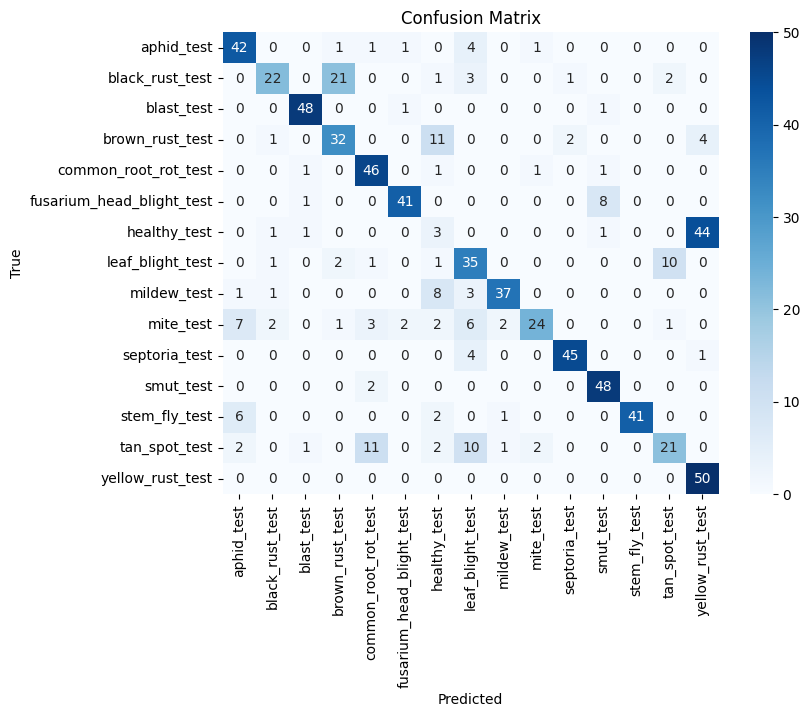

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()